## Parameter Recovery: Simulations (Oedema Oct 25)
#### BAYES/ KF Only



In [17]:
#preamble and imports

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import numpy as np
import hdf5storage as h5s
from mat73 import loadmat as loadmat73
from scipy.io import loadmat
from cmdstanpy import CmdStanModel
import os
from datetime import datetime

### Loading Rewards & Walks 

Loading in Daw's rewards and also the walks each participant played through. 

In [19]:
# Daw's walks from MATLAB: load (project_folder/behavioural_data/stimuli-gaussian.mat)
mat = loadmat("../behavioural_data/stimuli-gaussian.mat")

payoffs1 = mat["payoffs1"].astype(float)  # shape (700, 4)
payoffs2 = mat["payoffs2"].astype(float)
payoffs3 = mat["payoffs3"].astype(float)

rewards = np.empty((3, 300, 4), dtype=float) #see end of notebook for plots 
rewards[0, :, :] = payoffs1[:300, :]
rewards[1, :, :] = payoffs2[:300, :]
rewards[2, :, :] = payoffs3[:300, :]

del(payoffs1, payoffs2, payoffs3)

# Load behavioural data from MATLAB files

mat_hc   = "../behavioural_data/Control_Thal/Full_data_set_Control_Thal.mat"
mat_pre  = "../behavioural_data/Pre_Thal/Full_data_set_Pre_Thal.mat"
mat_post = "../behavioural_data/Post_Thal/Full_data_set_Post_Thal.mat"

hc_structs   = np.ravel(loadmat(mat_hc,   squeeze_me=True, struct_as_record=False)["Data"])
pre_structs  = np.ravel(loadmat(mat_pre,  squeeze_me=True, struct_as_record=False)["Data"])
post_structs = np.ravel(loadmat(mat_post, squeeze_me=True, struct_as_record=False)["Data"])

liverpool_post_subjects = np.array([4,7,9,11,12,13,15,19,24,27,29,31]) - 1
dundee_post_subjects    = np.array([1,2,3,5,6,8,10,14,16,17,18,20,21,22,23,25,26,28,30,32,33,34,35,36,37]) - 1

walks = {}
walks["HC"]            = [int(s.Walk) for s in hc_structs]
walks["PreTreat"]           = [int(s.Walk) for s in pre_structs]
walks["PostTreat"]     = [int(s.Walk) for s in post_structs]
walks["PostTreat_Liv"] = [int(post_structs[i].Walk) for i in liverpool_post_subjects]
walks["PostTreat_Dun"] = [int(post_structs[i].Walk) for i in dundee_post_subjects]

del (mat, mat_hc, mat_pre, mat_post,hc_structs, pre_structs, post_structs)

# And load the Parameters to be Recovered 
parameters_HDI_ranked = loadmat73('posterior_param_draws_ranked.mat')['posterior_param_draws_ranked']
groups = ['HC', 'PreTreat', 'PostTreat', 'PostTreat_Liv', 'PostTreat_Dun']



Compile & Simulate

In [8]:
# compile CmdStanModels for simulation 
BayesSMP_simulation = CmdStanModel(stan_file='../Stan/stan_simulations/BayesSMP_model_simulation.stan', force_compile=True)
BayesSMEP_simulation = CmdStanModel(stan_file='../Stan/stan_simulations/BayesSMEP_model_simulation.stan', force_compile=True)

14:36:46 - cmdstanpy - INFO - compiling stan file /home/isla/Projects/oedema_Oct25/Stan/stan_simulations/BayesSMP_model_simulation.stan to exe file /home/isla/Projects/oedema_Oct25/Stan/stan_simulations/BayesSMP_model_simulation
14:36:57 - cmdstanpy - INFO - compiled model executable: /home/isla/Projects/oedema_Oct25/Stan/stan_simulations/BayesSMP_model_simulation
14:36:57 - cmdstanpy - INFO - compiling stan file /home/isla/Projects/oedema_Oct25/Stan/stan_simulations/BayesSMEP_model_simulation.stan to exe file /home/isla/Projects/oedema_Oct25/Stan/stan_simulations/BayesSMEP_model_simulation
14:37:08 - cmdstanpy - INFO - compiled model executable: /home/isla/Projects/oedema_Oct25/Stan/stan_simulations/BayesSMEP_model_simulation


In [9]:
# set up global sim vars & placeholders for simulation data
chains = 1
nTrials = 300
nK = 5 # of parameter sets to simulate (3 times) per subject
nSubSims = 3
groups = ['HC', 'PreTreat', 'PostTreat', 'PostTreat_Liv', 'PostTreat_Dun']
master_OUT = './simulated_data/'

simulations = {group: {'BayesSMP': {}, 'BayesSMEP': {}} for group in groups}

for group in groups:
    nSubjects = len(walks[group])
    for model in ['BayesSMP','BayesSMEP']:
        simulations[group][model]['choice']     = np.empty((nSubjects, nK, nSubSims, nTrials), dtype=int)
        simulations[group][model]['reward_obt'] = np.empty((nSubjects, nK, nSubSims, nTrials), dtype=float)

In [10]:
# should disable logging here (messy notbook output)
# ---------- Simulate Play as BayesSMP (beta, persev) ----------

## this is a guaranteed unique  output folder based on time of simulation
dated_directory = datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "-simulations"

OUTDIR = os.path.join(master_OUT, dated_directory)
os.makedirs(OUTDIR, exist_ok=True)


model = 'BayesSMP'
simulationStan = BayesSMP_simulation

for group in groups:

    nSubjects = len(walks[group])
    params = parameters_HDI_ranked[group][model]['params']
    

    for subject in range(nSubjects):
        walk = walks[group][subject]
        walk = walk - 1  # to zero-indexed

        rewards_for_walk = rewards[walk, :, :]

        for draw in range(nK):
            beta = float(params['beta'][subject, draw])
            persev = float(params['persev'][subject, draw])

            data = {
                'nSubjects': 1,
                'nTrials': nTrials,
                'reward': rewards_for_walk,
                'beta': np.array([beta]),
                'persev': np.array([persev])
            }

            outdir = os.path.join(OUTDIR, group,model,f'subject_{subject+1:02d}', f'K{draw+1}')
            os.makedirs(outdir, exist_ok=True)

            simulation = simulationStan.sample(
                        data=data,
                        chains=chains,
                        iter_warmup=0,
                        iter_sampling=nSubSims,   # 3 reps in one CSV
                        adapt_engaged=False,
                        fixed_param=True,
                        output_dir=outdir,
                        show_console=False
                    )
            
            choice_array = simulation.stan_variable('choice')
            reward_obtained_array = simulation.stan_variable('reward_obt')

            simulations[group][model]['choice'][subject, draw, :, :] = choice_array[:,0,:].astype(int, copy=False)
            simulations[group][model]['reward_obt'][subject, draw, :, :] = reward_obtained_array[:,0,:]

# ---------- Simulate play as BayesSMEP (beta, persev) ----------
model = 'BayesSMEP'
simulationStan = BayesSMEP_simulation

for group in groups:

    nSubjects = len(walks[group])
    params = parameters_HDI_ranked[group][model]['params']
    

    for subject in range(nSubjects):
        walk = walks[group][subject]
        walk = walk - 1  # to zero-indexed

        rewards_for_walk = rewards[walk, :, :]

        for draw in range(nK):
            beta = float(params['beta'][subject, draw])
            phi = float(params['phi'][subject, draw])
            persev = float(params['persev'][subject, draw])

            data = {
                'nSubjects': 1,
                'nTrials': nTrials,
                'reward': rewards_for_walk,
                'beta': np.array([beta]),
                'phi': np.array([phi]),
                'persev': np.array([persev])
            }

            outdir = os.path.join(OUTDIR, group,model,f'subject_{subject+1:02d}', f'K{draw+1}')
            os.makedirs(outdir, exist_ok=True)

            simulation = simulationStan.sample(
                        data=data,
                        chains=chains,
                        iter_warmup=0,
                        iter_sampling=nSubSims,   # 3 reps in one CSV
                        adapt_engaged=False,
                        fixed_param=True,
                        output_dir=outdir,
                        show_console=False
                    )
            
            choice_array = simulation.stan_variable('choice')
            reward_obtained_array = simulation.stan_variable('reward_obt')

            simulations[group][model]['choice'][subject, draw, :, :] = choice_array[:,0,:].astype(int, copy=False)
            simulations[group][model]['reward_obt'][subject, draw, :, :] = reward_obtained_array[:,0,:]


# see end of notebook for plots 
h5s.savemat(os.path.join(OUTDIR, 'simulations_stan_struct.mat'),
            {'simulations': simulations},
            format='7.3')

14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.


14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:13 - cmdstanpy - INFO - CmdStan done processing.
14:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.


14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:14 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.
14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:15 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.


14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:16 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.
14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:17 - cmdstanpy - INFO - CmdStan done processing.


14:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.


14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:18 - cmdstanpy - INFO - CmdStan done processing.
14:37:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.


14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:19 - cmdstanpy - INFO - CmdStan done processing.
14:37:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.


14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.


14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:21 - cmdstanpy - INFO - CmdStan done processing.
14:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.


14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:22 - cmdstanpy - INFO - CmdStan done processing.
14:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.


14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:23 - cmdstanpy - INFO - CmdStan done processing.
14:37:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.


14:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:24 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.
14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:25 - cmdstanpy - INFO - CmdStan done processing.


14:37:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.
14:37:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:26 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.


14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:27 - cmdstanpy - INFO - CmdStan done processing.
14:37:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.


14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:28 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.


14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:29 - cmdstanpy - INFO - CmdStan done processing.
14:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.


14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:30 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.


14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:31 - cmdstanpy - INFO - CmdStan done processing.
14:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.
14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:32 - cmdstanpy - INFO - CmdStan done processing.


14:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.


14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:33 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.
14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


14:37:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:37:34 - cmdstanpy - INFO - CmdStan done processing.


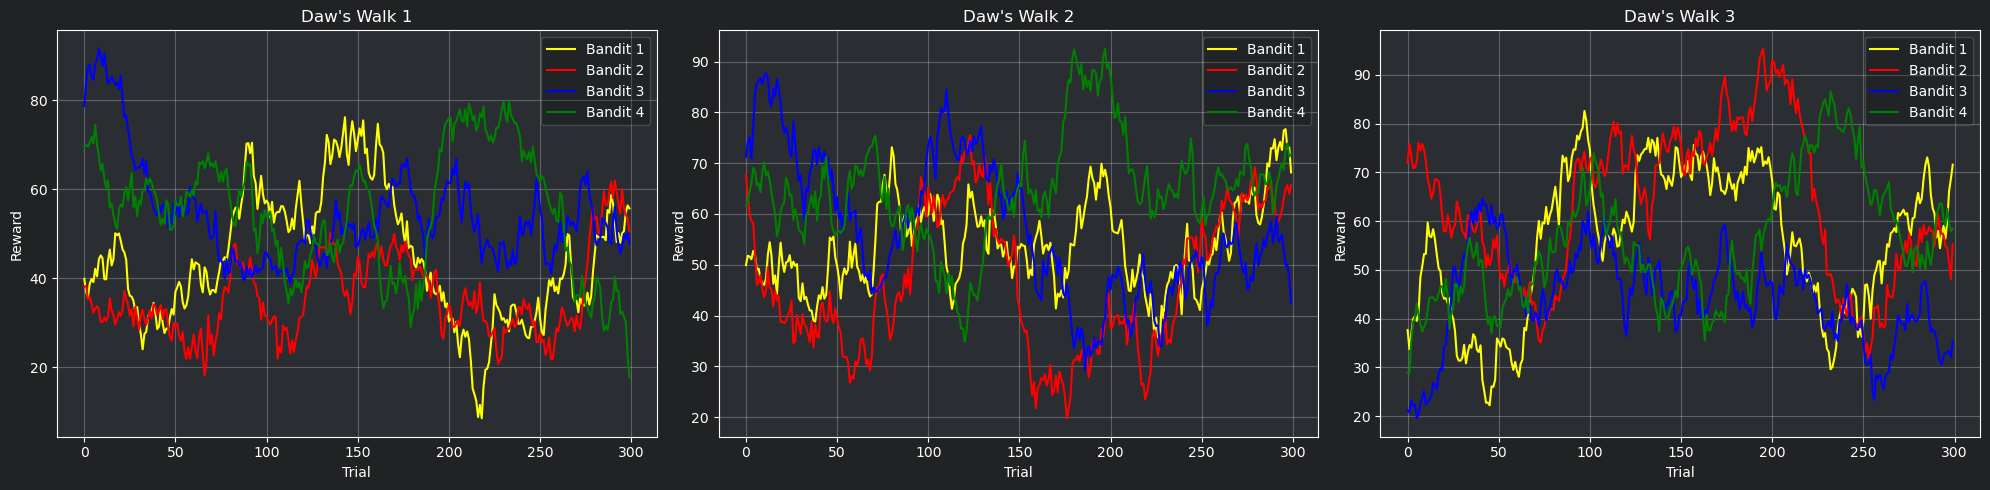

In [11]:
# & plot daws 
colours = ["yellow", "red", "blue", "green"]
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.patch.set_facecolor('#202224')  # figure background (dark grey)

for i, ax in enumerate(axes):
    ax.set_facecolor('#2a2d31')    # axes panel background (slightly lighter grey)
    for j in range(4):
        ax.plot(rewards[i, :, j], label=f'Bandit {j+1}', color=colours[j])
    ax.set_title(f'Daw\'s Walk {i+1}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Reward')
    ax.grid(True, alpha=0.25)
    ax.legend(frameon=True, framealpha=0.2)

plt.tight_layout()
plt.show()

In [12]:
def plot_simulated_plays(sims, params, group):
    # fixed settings for this project
    K, R = 5, 3
    palette = ["#00346B", "#7C3E00", "#A70003", "#00B6A7", "#14AD00"]

    # short names
    sim_smp   = sims[group]['BayesSMP']              # (nSubjects, K, R, nTrials)
    sim_smep  = sims[group]['BayesSMEP']
    params_smp  = params[group]['BayesSMP']['params']
    params_smep = params[group]['BayesSMEP']['params']

    nSubjects = sim_smp['reward_obt'].shape[0]
    nTrials   = sim_smp['reward_obt'].shape[-1]

    def lighten(color, f):
        r, g, b = to_rgb(color)
        return (r + (1 - r) * f, g + (1 - g) * f, b + (1 - b) * f)

    plt.style.use('dark_background')
    fig, axes = plt.subplots(nSubjects, 2, figsize=(16, 3 * nSubjects), sharex=True, sharey=True)
    fig.patch.set_facecolor('#202224')

    for subject in range(nSubjects):
        ax_smp, ax_smep = axes[subject, 0], axes[subject, 1]

        # ----- BayesSMP (left) -----
        for d in range(K):
            col    = palette[d]
            beta   = params_smp['beta'][subject, d]
            persev = params_smp['persev'][subject, d]
            label  = fr"d{d+1}: β={beta:.3f}, ρ={persev:.2f}"

            ax_smp.plot(range(1, nTrials + 1), sim_smp['reward_obt'][subject, d, 0, :], color=lighten(col, 0.00), lw=1.25, label=label)
            ax_smp.plot(range(1, nTrials + 1), sim_smp['reward_obt'][subject, d, 1, :], color=lighten(col, 0.35), lw=1.25)
            ax_smp.plot(range(1, nTrials + 1), sim_smp['reward_obt'][subject, d, 2, :], color=lighten(col, 0.65), lw=1.25)

        if subject == 0:
            ax_smp.set_title(f"{group} — BayesSMP")
        ax_smp.set_ylabel(f"subject {subject+1:02d}")
        if subject == nSubjects - 1:
            ax_smp.set_xlabel("trial")

        # ----- BayesSMEP (right) -----
        for d in range(K):
            col     = palette[d]
            beta    = params_smep['beta'][subject, d]
            phi     = params_smep['phi'][subject, d]
            persev  = params_smep['persev'][subject, d]
            label   = fr"d{d+1}: β={beta:.3f}, φ={phi:.2f}, ρ={persev:.2f}"

            ax_smep.plot(range(1, nTrials + 1), sim_smep['reward_obt'][subject, d, 0, :], color=lighten(col, 0.00), lw=1.25, label=label)
            ax_smep.plot(range(1, nTrials + 1), sim_smep['reward_obt'][subject, d, 1, :], color=lighten(col, 0.35), lw=1.25)
            ax_smep.plot(range(1, nTrials + 1), sim_smep['reward_obt'][subject, d, 2, :], color=lighten(col, 0.65), lw=1.25)

        if subject == 0:
            ax_smep.set_title(f"{group} — BayesSMEP")
            ax_smp.legend(ncol=1, fontsize=9, frameon=False)
            ax_smep.legend(ncol=1, fontsize=9, frameon=False)
        if subject == nSubjects - 1:
            ax_smep.set_xlabel("trial")

    plt.tight_layout()
    plt.show()

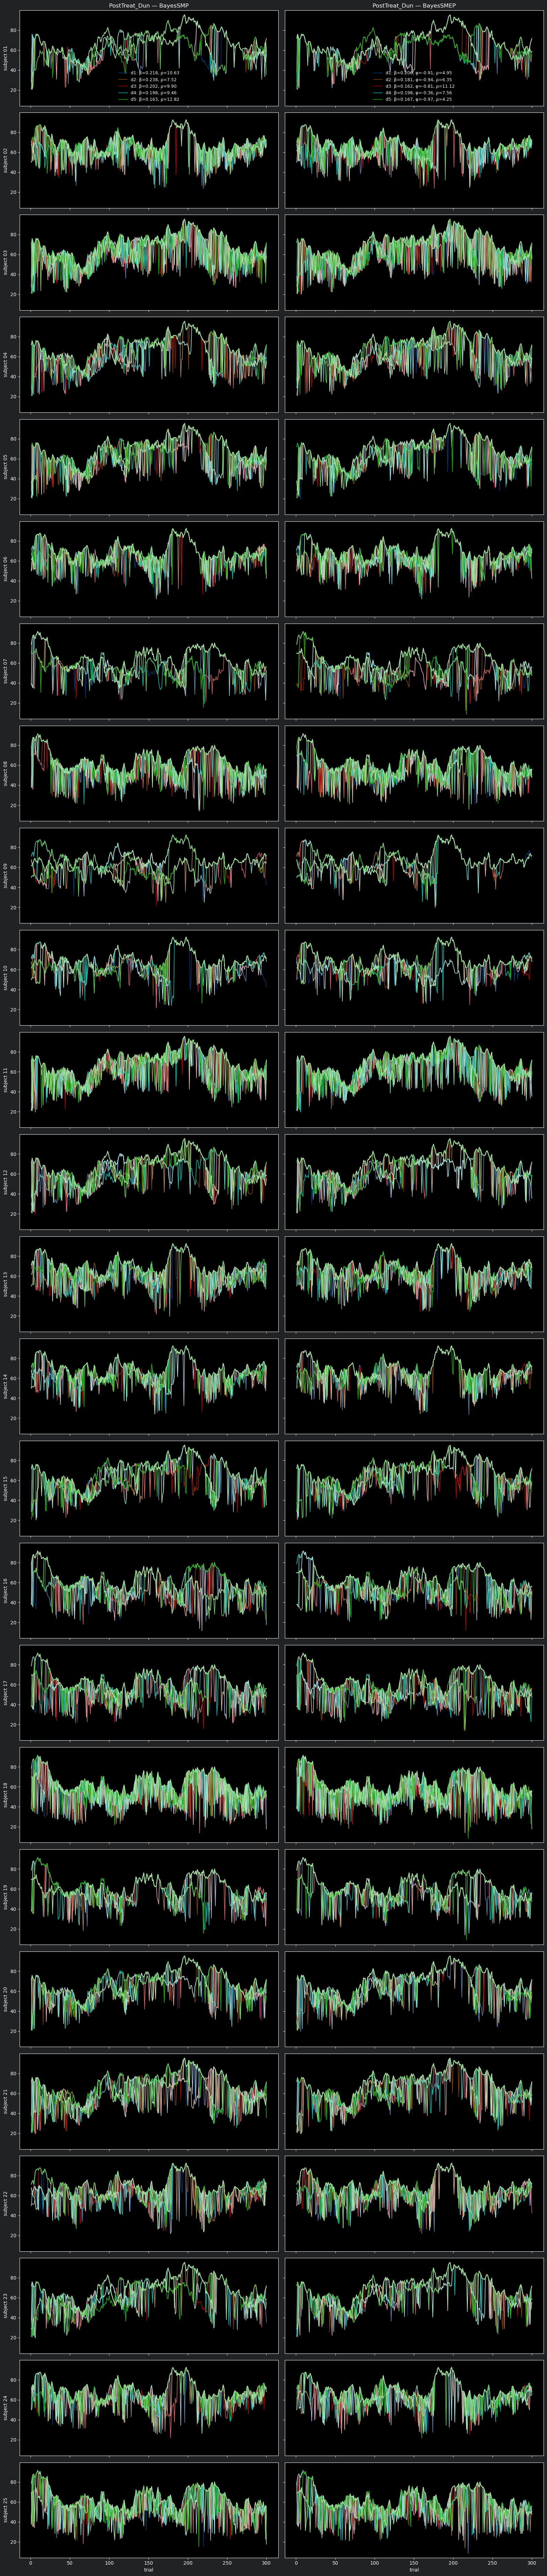

In [15]:
plot_simulated_plays(simulations, parameters_HDI_ranked, 'PostTreat_Dun')